<font size=6>**Titanic Disaster**</font>

In [1]:
# data analysis 
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# visualization defaults
plt.style.use('ggplot')
sns.set_style('whitegrid')

## 获取数据

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**变量解释：**

- Survived：存活与否，0-No，1-Yes
- Pclass：船舱等级，1-一等舱，2-二等舱，3-三等舱
- Name：姓名
- Sex：性别，只有Female和Male两种
- Age：年龄
- SibSp：同在船上的【兄弟姐妹(siblings)和配偶(spouses)】的总数
- Parch: 同在船上的【父母和孩子】的总数
- Ticket：船票的编号
- Fare：票价
- Cabin：客舱号
- Embarked：登船的港口，C = Cherbourg, Q = Queenstown, S = Southampton

## 探索性数据分析 (Exploratory Data Analysis, EDA)

### 缺失数据

- 训练集中共有乘客891名，Age属性有约20%的数据缺失，Cabin有约80%的数据缺失，Embarked有2条数据缺失，其它属性数据完整。
- 测试集中共有顾客418名，其中Age、Cabin缺失大量数据，Fare缺失一条数据。

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 属性分布及属性间的相关性

#### 样本分布 (Survived)

最后有约330个人活了下来，占乘客总数的37%，即**正样本：负样本 ≈ 4 : 6**。

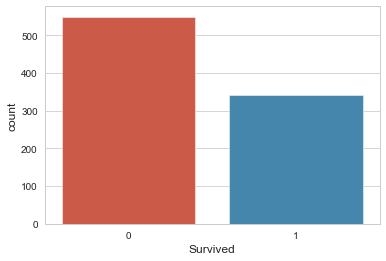

In [5]:
sns.countplot(x='Survived', data=train)

#### 类目属性

##### 性别 Sex

从下图中可以看出，女性的存活率明显高于男性，因此需将属性Sex纳入模型训练中，但是需将Sex转为数值变量。

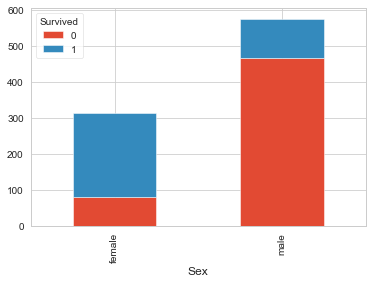

In [6]:
df = train.groupby(by='Sex')['Survived'].value_counts().unstack(level=1)
df.plot.bar(stacked=True)

##### 船舱等级 Pclass

从下面的图表中可以看出:

- 存活率：一等舱 > 二等舱 > 三等舱。这说明存活率和船舱等级关系密切。
- 平均年龄：一等舱 > 二等舱 > 三等舱。这说明年龄分布与船舱等级有关。
- SibSp & Parch：三等舱 > 一等舱 ≈ 二等舱
- Fare: 一等舱 >> 二等舱 > 三等舱。这说明Pclass越小Fare越高。

想法：

- Pclass需纳入模型训练中
- Pclass可以作为填充Age缺失值的重要依据

In [7]:
train.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


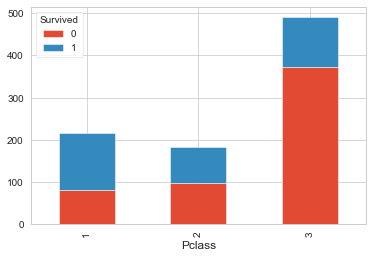

In [8]:
# 不同等级船舱乘客的存活情况
df = train.groupby(by='Pclass')['Survived'].value_counts().unstack(level=1)
df.plot(kind='bar', stacked=True)

#####  SibSp & Parch

- SibSp和Parch之间有一定的相关性，但和存活率之间的相关性较小

想法：

- SibSp和Parch的区别不大，可以将两个变量合并为一个属性family_size，family_size = SibSp + Parch
- 不同family_size的存活率不一样，故可以将family_size纳入模型中

In [9]:
train[['SibSp', 'Survived']].groupby('SibSp').mean().transpose()

SibSp,0,1,2,3,4,5,8
Survived,0.345395,0.535885,0.464286,0.25,0.166667,0.0,0.0


In [10]:
train[['Parch', 'Survived']].groupby('Parch').mean().transpose()

Parch,0,1,2,3,4,5,6
Survived,0.343658,0.550847,0.5,0.6,0.0,0.2,0.0


In [11]:
train['family_size'] = train['SibSp'] + train['Parch']
train.groupby('family_size').mean()['Survived']

family_size
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

##### 登船港口 Embarked

从下表中可以看出，C港口登船的乘客生还率最高，Q次之，S最低。

想法：

- 将embarked转换为数值变量，然后纳入模型

In [12]:
train.groupby(by='Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_size
Embarked,,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144,0.750000
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030,0.597403
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812,0.984472


#### 连续属性

##### 年龄 Age

从下图中可以看出：
- 乘客年龄分布为0～80岁，大部分乘客年龄集中在15～40岁。
- 0\~8岁的儿童存活率很高, 20\~35岁死亡率很高
- 60岁以上的老人死亡率很高，但年纪最大的那个80岁的人活下来了
- 随着船舱等级的上升，乘客的平均年龄增加

想法:

- 根据船舱等级填补年龄的缺失值
- 将年龄从连续值变为离散值，即设置不同的年龄区间。从下图中存活率的变化，可以大致将年龄分为以下几个区间：(0, 8], (8, 18], (18, 48], (48, 64], (64, 80]


Text(0.5, 1.0, 'Age distribution of different Pclass ')

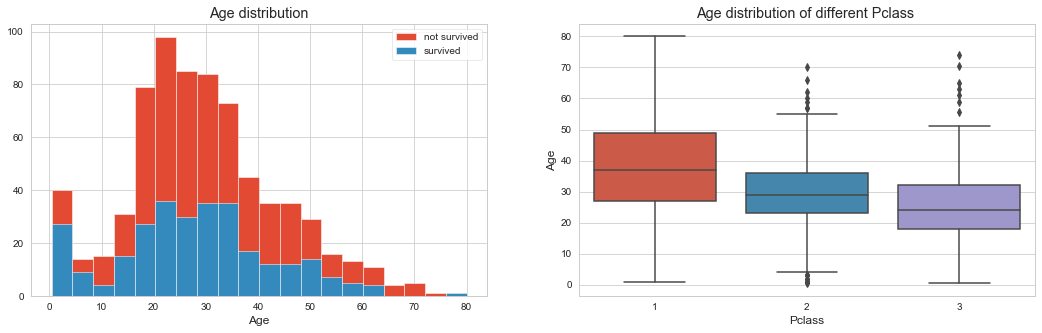

In [13]:
plt.subplots(1, 2, figsize=(18,5))

# 不同年龄区间的存活情况分布
plt.subplot(1, 2, 1)
sns.distplot(train['Age'].dropna(), kde=False, bins=20, hist_kws={"alpha": 1}, label='not survived') 
sns.distplot(train[train['Survived'] == 1]['Age'].dropna(), kde=False, bins=20, hist_kws={"alpha": 1}, label='survived') 
plt.legend()
plt.title('Age distribution')

# 不同船舱的年龄分布
plt.subplot(1, 2, 2)
sns.boxplot(x='Pclass', y='Age', data=train)
plt.title('Age distribution of different Pclass ')

##### 票价 Fare

从下图中可以看出：
- 票价的分布是非常偏斜的，80%的票价在30美元以下，而票价最高可达到512美元。
- 总体来说，票价越高，存活率也越高。

想法：

- 需将票价纳入模型
- 将票价离散化，即设置不同的票价区间

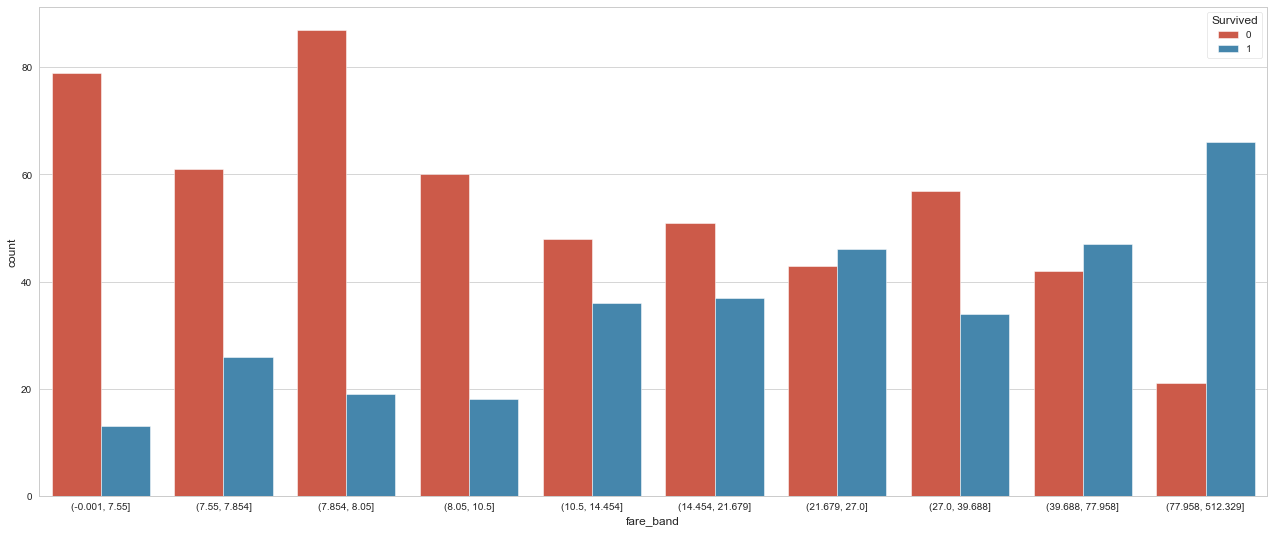

In [14]:
train['fare_band'] = pd.qcut(train['Fare'], 10)
plt.figure(figsize=(22, 9))
sns.countplot(x='fare_band', hue='Survived', data=train)

#### 混合型数据
##### 名字 Name

名字的信息较为复杂，但名字里的“Mr"、"Mrs”等称呼和年龄有关， 如“Master”的平均年龄为4.5岁，“Miss”为22岁，“Dr”为42岁。

想法：

- 新增一个属性title，根据title填充年龄的缺失值。
- title可作为填充Age缺失值的重要依据。

In [15]:
# 提取名字里的title
train['title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# 查看title的数量及对应的平均年龄
title_count = train['title'].value_counts()
title_mean_age = train.groupby('title').mean()['Age']
pd.concat([title_count, title_mean_age], axis=1, sort=True).sort_values('title', ascending=False)

,title,Age
Mr,517,32.368090
Miss,182,21.773973
Mrs,125,35.898148
Master,40,4.574167
Dr,7,42.000000
Rev,6,43.166667
Major,2,48.500000
Col,2,58.000000
Mlle,2,24.000000
Mme,1,24.000000


##### 客舱号 Cabin

理论上，Cabin能标记乘客的房间位置，而房间位置与乘客逃生情况息息相关，故Cabin应该能提供很重要的信息。但是由于Cabin数据较为分散，且缺失值很多，所以不太好利用。

In [16]:
train['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
D              3
C22 C26        3
              ..
B38            1
F38            1
A7             1
D30            1
C30            1
Name: Cabin, Length: 147, dtype: int64

将Cabin分为“有信息”和“无信息"两类，发现有Cabin信息的存活率要高得多，因此可以考虑将Cabin转为类目型变量have_cabin。

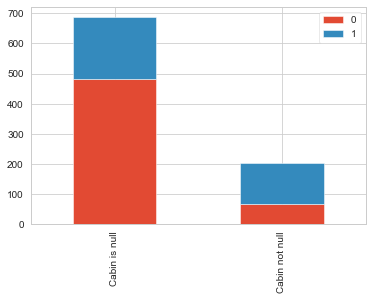

In [17]:
cabin = train['Survived'][train['Cabin'].isnull()].value_counts()
no_cabin = train['Survived'][train['Cabin'].notnull()].value_counts()
df = pd.DataFrame({'Cabin is null': cabin, 'Cabin not null': no_cabin})
df = df.stack().unstack(level=0)
df.plot.bar(stacked=True)

#### 小结

- 类目特征：Pclass可直接使用，Sex和Embarked需先转换为数值变量
- 需离散化的连续变量：Age, Fare
- 增设变量: title, family_size, have_cabin

## 特征工程 (Feature Engineering)

因为训练集和测试集必须采用相同的处理方式，所以先将两者合并到一个数据集all_data中，后面共同处理。

在all_data中，训练集的下标为0\~890，测试集的下标为891\~1308.

In [18]:
y_train = train['Survived']
all_data = pd.concat([train.drop(['family_size', 'Survived', 'title', 'fare_band'], axis=1), test], axis=0, sort=False)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


### 混合型数据

#### Name：增设title

提取Name中的title，并单设一个title属性

In [19]:
# 提取名字里的title
all_data['title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 将title划分为Mr、Mrs、Miss、Master、Dr、Rev、Rare七类
all_data['title'] = all_data['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['title'] = all_data['title'].replace(['Mlle','Ms'], 'Miss')
all_data['title'] = all_data['title'].replace('Mme', 'Mrs')

# 查看title的数量及对应的平均年龄
title_count = all_data['title'].value_counts()
title_mean_age = all_data.groupby('title').mean()['Age']
pd.concat([title_count, title_mean_age], axis=1, sort=True).sort_values('title', ascending=False)

,title,Age
Mr,757,32.252151
Miss,264,21.824366
Mrs,198,36.918129
Master,61,5.482642
Rare,13,48.461538
Dr,8,43.571429
Rev,8,41.250000


#### Cabin：增设have_cabin

按“Cabin信息的有无”将变量Cabin转换为类目变量have_cabin，0表示无，1表示有。

In [20]:
all_data['have_cabin'] = pd.get_dummies(all_data['Cabin'].notnull(), drop_first=True)

### 类目属性

#### Sex 转为数值变量
转为数值变量，1-male，0-female

In [21]:
all_data['Sex'] = all_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#### Embarked 转为数值变量
- 填补缺失值：查看数据缺失的两个乘客的信息，发现两个人都是一等舱，且客舱号、票号、票价都一样，所以猜测两人是同伴，且在同一港口登船。另外，根据前面的分析，一等舱的乘客在C港口登船的概率最高，故猜测她们的Embarked=C。
- 转为数值变量：0-C, 1-Q, 2-S

In [22]:
all_data[all_data['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,have_cabin
61,62,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,Miss,1
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,Mrs,1


In [23]:
# 填补缺失值
all_data['Embarked'].fillna('C', inplace=True)

# 转换为数值变量
all_data['Embarked'] = all_data['Embarked'].map({'C': 0, 'Q': 1, 'S':2})

#### SibSp & Parch 合并为family_size

In [24]:
all_data['family_size'] = all_data['SibSp'] + all_data['Parch']

### 连续属性

#### Age填缺失值+离散化

- 根据title和Pclass对Age的缺失值进行填充：
    - 如果title是“Miss”/“Master”/“Dr”/“Rev”/“Rare”，按title填充缺失值；
    - 其它则按船舱等级填充缺失值。

In [25]:
all_data.groupby('title').mean()['Age']

title
Dr        43.571429
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Rare      48.461538
Rev       41.250000
Name: Age, dtype: float64

In [26]:
# 填充年龄的缺失值
def ImputAge(cols):
    Age = cols[0]
    Pclass = cols[1]
    title = cols[2]
    
    if pd.isnull(Age):
        if title == 'Miss':
            return 21.8
        if title == 'Master':
            return 5.5
        if title == 'Dr':
            return 43.5
        if title == 'Rev':
            return 41.2
        if title == 'Rare':
            return 48.5
        if Pclass == 1:
            return 38.2
        if Pclass == 2:
            return 29.9
        return 25.1
    return Age

all_data['Age'] = all_data[['Age', 'Pclass', 'title']].apply(ImputAge, axis=1)

- 设置不同的年龄区间age_band，并按存活率大小对他们编号:
    - 0：0～8
    - 2：8～18
    - 3：18～48
    - 1：48～64
    - 4：64～80

In [27]:
# 划分不同的年龄区间:
def AgeBand(age):
    if 0 < age <= 8:
        return 0
    if 8 < age <= 18:
        return 2
    if 18 < age <= 48:
        return 3
    if 48 < age <= 64:
        return 1
    return 4

all_data['age_band'] = all_data['Age'].apply(AgeBand)

In [28]:
pd.concat([all_data.iloc[:891], y_train], axis=1).groupby('age_band').mean()['Survived']

age_band
0    0.655172
1    0.434783
2    0.400000
3    0.357784
4    0.090909
Name: Survived, dtype: float64

#### Fare填缺失值+离散化
- 填补Fare的缺失值
- 对Fare进行分区

查看Fare缺失的乘客的信息

In [29]:
all_data[all_data['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,have_cabin,family_size,age_band
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NaN,2,Mr,0,0,1


该乘客为三等舱，故在缺失值处填入三等舱的平均票价：

In [30]:
all_data.groupby('Pclass').mean()['Fare']

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [31]:
all_data['Fare'].fillna(13.3, inplace=True)

对Fare进行分区：

In [32]:
pd.qcut(all_data['Fare'], 4)

0        (-0.001, 7.896]
1      (31.275, 512.329]
2        (7.896, 14.454]
3      (31.275, 512.329]
4        (7.896, 14.454]
             ...        
413      (7.896, 14.454]
414    (31.275, 512.329]
415      (-0.001, 7.896]
416      (7.896, 14.454]
417     (14.454, 31.275]
Name: Fare, Length: 1309, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.275] < (31.275, 512.329]]

In [33]:
all_data.loc[ all_data['Fare'] <= 7.896, 'fare_band'] = 0
all_data.loc[(all_data['Fare'] > 7.896) & (all_data['Fare'] <= 14.454), 'fare_band'] = 1
all_data.loc[(all_data['Fare'] > 14.454) & (all_data['Fare'] <= 31.275), 'fare_band']   = 2
all_data.loc[ all_data['Fare'] > 31.275, 'fare_band'] = 3
all_data['fare_band'] = all_data['fare_band'].astype(int)

In [34]:
pd.concat([all_data.iloc[:891], y_train], axis=1).groupby('fare_band').mean()['Survived']

fare_band
0    0.197309
1    0.308756
2    0.432203
3    0.600000
Name: Survived, dtype: float64

可见，随着fare_band数值的增大，存活率也相应增大。

In [35]:
all_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,have_cabin,family_size,age_band,fare_band
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,Mr,0,1,3,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,Mrs,1,1,3,3
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,Miss,0,0,3,1


### 删除无用的属性

In [36]:
# 删除无用的变量
all_data2 = all_data.drop(['PassengerId', 'Name','Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'title', ], axis=1)
all_data2.head()

,Pclass,Sex,Embarked,have_cabin,family_size,age_band,fare_band
0,3,1,2,0,1,3,0
1,1,0,0,1,1,3,3
2,3,0,2,0,0,3,1
3,1,0,2,1,1,3,3
4,3,1,2,0,0,3,1


### 小结

In [37]:
# 查看变量之间的相关性
pd.concat([all_data2.iloc[:891], y_train], axis=1).corr()

,Pclass,Sex,Embarked,have_cabin,family_size,age_band,fare_band,Survived
Pclass,1.000000,0.131900,0.170334,-0.725541,0.065997,0.047791,-0.638299,-0.338481
Sex,0.131900,1.000000,0.115513,-0.140391,-0.200988,0.083159,-0.245160,-0.543351
Embarked,0.170334,0.115513,1.000000,-0.169961,0.069434,0.014627,-0.124310,-0.174199
have_cabin,-0.725541,-0.140391,-0.169961,1.000000,-0.009175,-0.069868,0.504117,0.316912
family_size,0.065997,-0.200988,0.069434,-0.009175,1.000000,-0.330465,0.446415,0.016639
age_band,0.047791,0.083159,0.014627,-0.069868,-0.330465,1.000000,-0.222785,-0.150349
fare_band,-0.638299,-0.245160,-0.124310,0.504117,0.446415,-0.222785,1.000000,0.303336
Survived,-0.338481,-0.543351,-0.174199,0.316912,0.016639,-0.150349,0.303336,1.000000


## 模型选择

这是一个监督学习+二分类问题，可以选择的模型有很多，这里我用交叉验证的方法选出效果最好的模型。

In [38]:
X_train = all_data.iloc[:891][[ 'Pclass', 'Sex','Embarked','age_band', 'have_cabin', 'fare_band', 'family_size']]
y_train = train['Survived']
X_test = all_data.iloc[891:][[ 'Pclass', 'Sex','Embarked','age_band', 'have_cabin', 'fare_band', 'family_size']]

In [39]:
# Importing packages for modelling.

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, learning_curve, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [40]:
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')

# Support Vector Machine
svc = SVC(gamma='auto')

# Random Forests
rf = RandomForestClassifier(n_estimators=10)

# Decision Trees
dt = DecisionTreeClassifier()

# KNN
knn = KNeighborsClassifier()

# Stochaic Gradien Descent
sgd = SGDClassifier()

estimators = [logreg, svc, rf, dt, knn, sgd]

In [41]:
alg_names = ['Logistic Regression', 'SVM', 'Random Forest', 'Decision Tree', 'KNN', 'SGD']
cols = ['Train Accuracy', 'Test Accuracy', 'Fit Time']
alg_compare = pd.DataFrame(index=alg_names, columns=cols)

In [42]:
for i in range(6):
    estimator = estimators[i]
    res = cross_validate(estimator, X_train, y_train, cv=10, return_train_score=True)
    alg_compare.iloc[i, 0] = res['train_score'].mean()
    alg_compare.iloc[i, 1] = res['test_score'].mean()
    alg_compare.iloc[i, 2] = res['fit_time'].mean()

In [43]:
alg_compare.sort_values('Test Accuracy', ascending=False)

,Train Accuracy,Test Accuracy,Fit Time
Random Forest,0.890759,0.827187,0.0106808
Decision Tree,0.893753,0.823842,0.00239313
SVM,0.82978,0.821569,0.0153619
KNN,0.847238,0.812693,0.00239236
Logistic Regression,0.800226,0.796961,0.00867655
SGD,0.739004,0.745111,0.00487976


绘制各个模型的学习曲线，判断模型状态。

In [44]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    Arguments:
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=10, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"training set size")
        plt.ylabel(u"score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"CV score")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

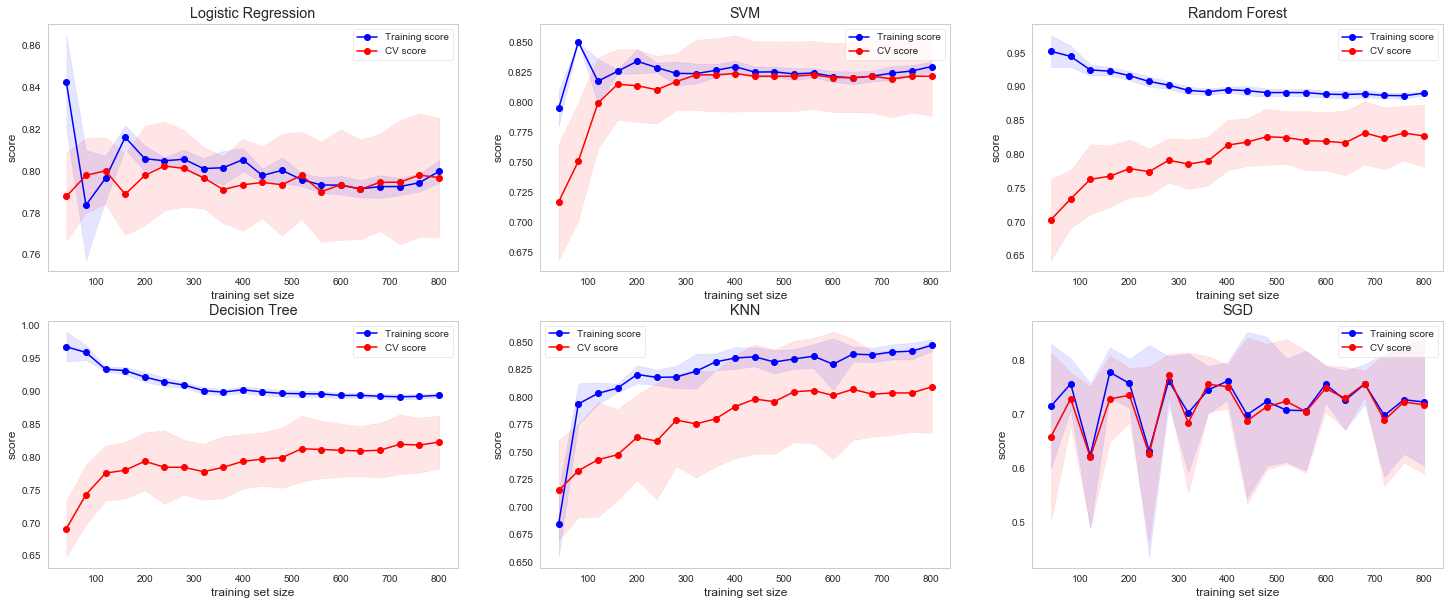

In [45]:
plt.subplots(2, 3, figsize=(25,10))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plot_learning_curve(estimators[i], alg_names[i], X_train, y_train)

- 过拟合：随机森林，决策树，KNN
- 合适：logistic Regression，SVM，SGD

从以上分析中可以看出，随机森林和决策树的预测效果最好，SVM和logistic回归次之，而SGD则和它们差距较大。

我在这里选择使用logistic回归，是因为“Titanic灾难”项目是一个数据分析入门项目，而logistic回归模型最为简单。

## 模型优化

In [46]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [47]:
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': prediction})
output.to_csv('logistic_predictions', index=False)

将预测结果提交Kaggle，准确率76.3%，而“预测全部女性存活”的准确率为77.5%，说明我的模型还有待优化。

In [48]:
# 原始模型的预测准确率,这将作为我后续衡量一个优化方法是否有用的标准
origin_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', origin_res['train_score'].mean())
print('Test Accuracy: ', origin_res['test_score'].mean())

Train Accuracy:  0.8002261187748101
Test Accuracy:  0.7969614686187719


### 绘制学习曲线

(0.7868728351793077, 0.03695309882272213)

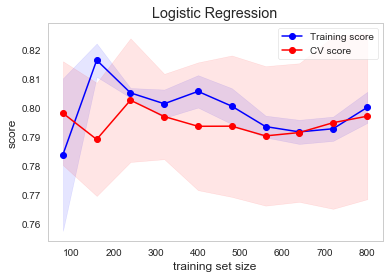

In [49]:
# 绘制学习曲线,
plot_learning_curve(model,
                    'Logistic Regression',
                    X_train,
                    y_train,
                    ylim=None,
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

从上图来看，我的模型的拟合状态是合适的，既没有过拟合也没有欠拟合。

### 查看模型系数

In [50]:
pd.DataFrame({"columns":X_train.columns, "coef":model.coef_[0]})

,columns,coef
0,Pclass,-0.437314
1,Sex,-2.686967
2,Embarked,-0.224267
3,age_band,-0.422353
4,have_cabin,0.591052
5,fare_band,0.271618
6,family_size,-0.316131


分析：
- Sex的系数权重最大
- Pclass和age_band、have_cabin的权重也较大

### Bad Cases

将原训练集分为训练集x_train_1和验证集x_cv_1两部分，让模型在x_train_1上拟合，在x_cv_1上测试，然后进行错误分析。

In [51]:
# 将训练集按7:3的比例随机拆分为训练集和验证集
x_train_1, x_cv_1, y_train_1, y_cv_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

logistic_reg = LogisticRegression(solver='lbfgs')
logistic_reg.fit(x_train_1, y_train_1)
pred = logistic_reg.predict(x_cv_1)

# bad ceses对应的下标
bad_cases_index = list(y_cv_1[pred != y_cv_1].index)
# 提取bad cases的原始数据
bad_cases = pd.concat([X_train, y_train], axis=1).loc[bad_cases_index]

bad_cases.head()

,Pclass,Sex,Embarked,age_band,have_cabin,fare_band,family_size,Survived
680,3,0,1,3,0,1,0,0
6,1,1,2,1,1,3,0,0
17,2,1,2,3,0,1,0,1
430,1,1,2,3,1,2,0,1
437,2,0,2,3,0,2,5,1


接下来对bad cases进行分析。

### 性别

In [52]:
bad_cases.groupby(by='Sex')['Survived'].value_counts().unstack(level=1)

Survived,0,1
Sex,,
0,17,3
1,6,35


In [53]:
# 女性存活情况以及Pclass分布
bad_cases[bad_cases['Sex'] == 0][['Survived', 'Pclass']].groupby('Pclass')['Survived'].value_counts().unstack()

Survived,0,1
Pclass,,
1,1.0,NaN
2,2.0,1.0
3,14.0,2.0


In [54]:
# 男性存活情况以及Pclass分布
bad_cases[bad_cases['Sex'] == 1][['Survived', 'Pclass']].groupby('Pclass')['Survived'].value_counts().unstack()

Survived,0,1
Pclass,,
1,6.0,13.0
2,NaN,4.0
3,NaN,18.0


从上面的数据可知：bad cases里有56%是“活下来的男性（一等舱和三等舱居多）”，28%是“没活下来的女性（82%为三等舱）”，10%是“没活下来的男性（全为一等舱）”。

可见，性别在模型中的系数权重过大反而导致了大量的预测错误，因此应该加大Pclass、Age等属性在模型系数中的权重，以平衡性别的影响。

### 年龄

从下图中可以看出，age_band=3的预测错误数最多，且大多为存活下来的情况。
这说明只是将年龄进行分区还不够，需要单设特殊的年龄段。

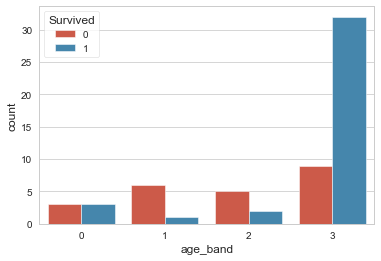

In [55]:
sns.countplot(x='age_band', hue='Survived', data=bad_cases) 

In [56]:
idx = bad_cases[bad_cases['age_band'] == 3].index
df = pd.concat([all_data[:891], y_train], axis=1).iloc[idx]

df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,have_cabin,family_size,age_band,fare_band,Survived
680,681,3,"Peters, Miss. Katie",0,21.8,0,0,330935,8.1375,NaN,1,Miss,0,0,3,1,0
17,18,2,"Williams, Mr. Charles Eugene",1,29.9,0,0,244373,13.0000,NaN,2,Mr,0,0,3,1,1
430,431,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",1,28.0,0,0,110564,26.5500,C52,2,Mr,1,0,3,2,1
437,438,2,"Richards, Mrs. Sidney (Emily Hocking)",0,24.0,2,3,29106,18.7500,NaN,2,Mrs,0,5,3,2,1
821,822,3,"Lulic, Mr. Nikola",1,27.0,0,0,315098,8.6625,NaN,2,Mr,0,0,3,1,1


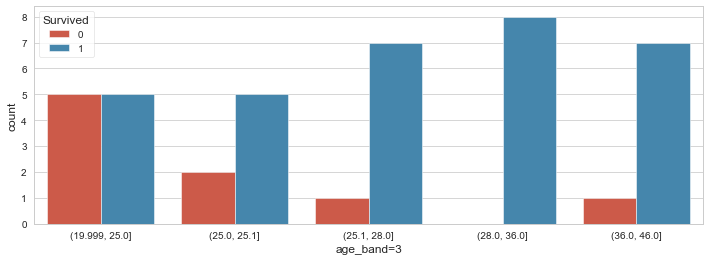

In [57]:
df['age_band=3'] = pd.qcut(df['Age'], 5)
plt.figure(figsize=(12, 4))
sns.countplot(x='age_band=3', hue='Survived', data=df)

#### 新增属性“middle_age”

In [58]:
X_train['middle_age'] = train['Age'].apply(lambda x: 32 <= x <= 36)

# 原始模型的预测准确率,这将作为我后续衡量一个优化方法是否有用的标准
middle_age_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', middle_age_res['train_score'].mean())
print('Test Accuracy: ', middle_age_res['test_score'].mean())

if middle_age_res['test_score'].mean() > origin_res['test_score'].mean():
    print('此方法有效!')
else:
    print('此方法无效！')

Train Accuracy:  0.8035933269175775
Test Accuracy:  0.7980600953353761
此方法有效!


In [59]:
all_data['middle_age'] = all_data['Age'].apply(lambda x: 32 <= x <= 36)

#### 新增属性“child”

In [60]:
# 筛选child的年龄分区点
ages = [4, 8, 12, 16]
for age in ages:
    print('age: ', age)
    X_train['child'] = train['Age'].apply(lambda x: x <= age)
    
    tmp = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
    print('Train Accuracy: ', tmp['train_score'].mean())
    print('Test Accuracy: ', tmp['test_score'].mean())
    print('-'*40)

age:  4
Train Accuracy:  0.8160632476098044
Test Accuracy:  0.8070366587220519
----------------------------------------
age:  8
Train Accuracy:  0.8186818575286186
Test Accuracy:  0.8126044149358757
----------------------------------------
age:  12
Train Accuracy:  0.8113244691701389
Test Accuracy:  0.8025422766995801
----------------------------------------
age:  16
Train Accuracy:  0.8090807020303542
Test Accuracy:  0.8047891839745773
----------------------------------------


可见，age=8时效果提升最大，故设置年龄<=8岁的为child，并新增child属性。

In [61]:
X_train['child'] = train['Age'].apply(lambda x: x <= 8)

# 原始模型的预测准确率,这将作为我后续衡量一个优化方法是否有用的标准
child_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', child_res['train_score'].mean())
print('Test Accuracy: ', child_res['test_score'].mean())

if child_res['test_score'].mean() > middle_age_res['test_score'].mean():
    print('此方法有效!')
else:
    print('此方法无效！')

Train Accuracy:  0.8186818575286186
Test Accuracy:  0.8126044149358757
此方法有效!


In [62]:
all_data['child'] = all_data['Age'].apply(lambda x: x <= 8)

### Cabin

在前面，我们只利用了“乘客是否有Cabin”这一信息，但没有利用Cabin中具体的信息。

在Google中搜索泰坦尼克号的布局，可知Cabin中的首字母表示甲板号，其中A、B、C甲板只开设一等舱，D、E甲板一、二、三等舱都有，F、G甲板有二、三等舱。

<img src="Cabin info.png">

In [63]:
# 按甲板号对乘客进行分类，其中没有客舱信息的统一分到“M”类
train['Deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')
train[['Deck', 'Pclass', 'Survived']].groupby(['Deck', 'Pclass']).count().transpose()

Deck       A   B   C   D      E        F     G   M            T
Pclass     1   1   1   1  2   1  2  3  2  3  3   1    2    3  1
Survived  15  47  59  29  4  25  4  3  8  5  4  40  168  479  1

In [64]:
# 不同甲板的平均票价和存活率
train[['Deck', 'Fare', 'Survived']].groupby('Deck').mean().transpose()

Deck,A,B,C,D,E,F,G,M,T
Fare,39.623887,113.505764,100.151341,57.244576,46.026694,18.696792,13.58125,19.157325,35.5
Survived,0.466667,0.744681,0.593220,0.757576,0.750000,0.615385,0.50000,0.299854,0.0


从上面两个表格中可以看到：

- A、B、C中100%为一等舱乘客
- D中88%为一等舱乘客，12%为二等舱乘客
- E中78%为一等舱乘客，13%为二等舱乘客，9%为三等舱乘客
- F中62%为二等舱乘客，38%为三等舱乘客
- G中100%为一等舱乘客
- M中6%为一等舱乘客，24%为二等舱乘客，79%为三等舱乘客
- T中只有一名一等舱乘客。理论上T甲板是不住人的，所以可能是信息错误。单独查阅这名乘客的信息，发现他的票价为35.5，比较接近A甲板的票价平均值，因此令这名乘客的Deck信息为A。

In [65]:
idx = train[train['Deck'] == 'T'].index
train.loc[idx, 'Deck'] = 'A'

In [66]:
# 去掉原本的have_cabin属性
X_train.drop('have_cabin', axis=1, inplace=True)

将甲板号转为编号，编号按该甲板的存活率从小到大变化，依次是：M-0，A-1，G-2，C-3，F-4，B-5，E-6，D-6.（D、E性质相似，可以合并到一类）

In [67]:
X_train['Deck'] = train['Deck']
X_train['Deck'] = X_train['Deck'].map({'A':1, 'B':5, 'C':3, 'D':6, 'E':6, 'F':4, 'G':2, 'M': 0})
X_train.head()

,Pclass,Sex,Embarked,age_band,fare_band,family_size,middle_age,child,Deck
0,3,1,2,3,0,1,False,False,0
1,1,0,0,3,3,1,False,False,3
2,3,0,2,3,1,0,False,False,0
3,1,0,2,3,3,1,True,False,3
4,3,1,2,3,1,0,True,False,0


In [68]:
# 检测模型改善情况
Deck_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', Deck_res['train_score'].mean())
print('Test Accuracy: ', Deck_res['test_score'].mean())
if Deck_res['test_score'].mean() > child_res['test_score'].mean():
    print('此改进方法有效!')
else:
    print('此方法无效！')

Train Accuracy:  0.8176841952407271
Test Accuracy:  0.8126168993303825
此改进方法有效!


In [69]:
all_data['Deck'] = all_data['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')
idx = all_data[all_data['Deck'] == 'T'].index
all_data.loc[idx, 'Deck'] = 'A'
all_data['Deck'] = all_data['Deck'].map({'A':1, 'B':5, 'C':3, 'D':6, 'E':6, 'F':4, 'G':2, 'M': 0})

all_data.drop('have_cabin', axis=1, inplace=True)

### Family size

前面我们只是计算了每个人的family size，但没有再具体分析它对结果的影响。仔细分析数据可以发现：

- family_size = 0, 存活率偏低
- family_size = 1~3，存活率最高
- family_size = 4~6，存活率更低
- family_size >6，存活率为0

In [70]:
train[['family_size', 'Survived']].groupby('family_size').mean().transpose()

family_size,0,1,2,3,4,5,6,7,10
Survived,0.303538,0.552795,0.578431,0.724138,0.2,0.136364,0.333333,0.0,0.0


重新对family_size分组:

In [71]:
def family_size(family_size):
    if family_size == 0:
        return 0
    if 1 <= family_size <= 3:
        return 1
    if 4 <= family_size <= 6:
        return 2
    return 3

X_train['family_size'] = train['family_size'].apply(family_size)

In [72]:
family_size_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', family_size_res['train_score'].mean())
print('Test Accuracy: ', family_size_res['test_score'].mean())
if family_size_res['test_score'].mean() > Deck_res['test_score'].mean():
    print('此改进方法有效!')
else:
    print('此方法无效！')  

Train Accuracy:  0.8214243789487419
Test Accuracy:  0.8103192032686415
此方法无效！


In [73]:
all_data['family_size'] = all_data['family_size'].apply(family_size)

### Ticket

在前面我们完全没有用到Ticket属性，但仔细分析会发现Ticket中也有有用的信息。

- 测试集乘客共891名，而Ticket只有681张，这说明有很多乘客共用一张套票。
- 共用一张套票的大概率是同伴，因此我们可以根据票的出现频率判断一个乘客的同伴数量。
- 同伴数量为2\~4的存活率最高，1次之，5\~7最低。

In [74]:
print('the number of passengers: ', train['Ticket'].count())
print('the number of Tickets:    ', train['Ticket'].nunique())

the number of passengers:  891
the number of Tickets:     681


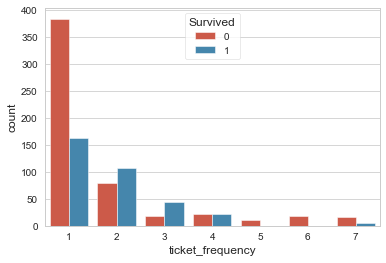

In [75]:
train['ticket_frequency'] = train.groupby('Ticket')['Ticket'].transform('count')
sns.countplot(x='ticket_frequency', hue='Survived', data=train)

In [76]:
# 把ticket_frequency属性加入训练集
X_train['ticket_frequency'] = train['ticket_frequency']

# 对tickt_frequency进行分组：
# 1 - 0， 2~4 - 1， > 4 - 2
def company(tickt_frequency):
    if tickt_frequency == 1:
        return 0
    if 1 < tickt_frequency <= 4:
        return 1
    return 2

X_train['ticket_frequency'] = train['ticket_frequency'].apply(company)

In [77]:
# 检测模型改善情况
ticket_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', ticket_res['train_score'].mean())
print('Test Accuracy: ', ticket_res['test_score'].mean())
if ticket_res['test_score'].mean() > family_size_res['test_score'].mean():
    print('此改进方法有效!')
else:
    print('此方法无用！')

Train Accuracy:  0.821798599452414
Test Accuracy:  0.8091956077630235
此方法无用！


### 新增属性“alone”

family_size=0和ticket_frequency=1的人，可以判断为独自一人。

In [78]:
X_train.head()

,Pclass,Sex,Embarked,age_band,fare_band,family_size,middle_age,child,Deck,ticket_frequency
0,3,1,2,3,0,1,False,False,0,0
1,1,0,0,3,3,1,False,False,3,0
2,3,0,2,3,1,0,False,False,0,0
3,1,0,2,3,3,1,True,False,3,1
4,3,1,2,3,1,0,True,False,0,0


In [79]:
def Alone(cols):
    family_size = cols[0]
    ticket_freq = cols[1]
    if family_size == 0 and ticket_freq == 1:
        return 1
    return 0

X_train['alone'] = X_train[['family_size', 'ticket_frequency']].apply(Alone, axis=1)

In [80]:
alone_res = cross_validate(logreg, X_train.drop('ticket_frequency', axis=1), y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', alone_res['train_score'].mean())
print('Test Accuracy: ', alone_res['test_score'].mean())
if alone_res['test_score'].mean() > Deck_res['test_score'].mean():
    print('此方法有效!')
else:
    print('此方法无效！')  

Train Accuracy:  0.8203017186008568
Test Accuracy:  0.8126044149358757
此方法无效！


In [81]:
X_train.drop('alone', axis=1, inplace=True)
X_train.drop('ticket_frequency', axis=1, inplace=True)

### Embarked

在测试集中，Embarked有两个缺失数据。前面我根据乘客信息合理猜测他们是同伴且都从C港口登船。但是后来我在Google中查找到了关于二者的信息：Martha Evelyn和Amelie Icard是主仆关系，二者从S港口登船。（网页链接：https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html）

In [82]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,fare_band,title,Deck,ticket_frequency
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,"(77.958, 512.329]",Miss,B,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,"(77.958, 512.329]",Mrs,B,2


In [83]:
# 订正训练集中的错误信息：
idx = train[train['Embarked'].isnull()].index
X_train.loc[idx, 'Embarked'] = 2

In [84]:
# 检测模型改善情况
Embarked_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', Embarked_res['train_score'].mean())
print('Test Accuracy: ', Embarked_res['test_score'].mean())

if Embarked_res['test_score'].mean() > family_size_res['test_score'].mean():
    print('此改进方法有效!')
else:
    print('此方法无用！')

Train Accuracy:  0.8214243789487419
Test Accuracy:  0.8103192032686415
此方法无用！


仅两条错误信息的纠正对模型的改善效果不大，但是通过查阅资料来补充数据的方式仍然是重要的。

In [85]:
all_data.loc[idx, 'Embarked'] = 2

### Title

前面我们只利用title的信息来填充年龄，并没有直接让title参与结果的预测，但通过分析我发现，不同title的人存活率是不一样的：

- 在关于性别的称呼中，Mrs和Miss的存活率最高, Master次之，Mr很低
- 在关于职位的称呼中，Dr和Rare的存活率较高，Rev存活率为零。

In [86]:
train.groupby('title').mean()['Survived']

title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [87]:
X_train.head()

,Pclass,Sex,Embarked,age_band,fare_band,family_size,middle_age,child,Deck
0,3,1,2,3,0,1,False,False,0
1,1,0,0,3,3,1,False,False,3
2,3,0,2,3,1,0,False,False,0
3,1,0,2,3,3,1,True,False,3
4,3,1,2,3,1,0,True,False,0


In [88]:
# 把title属性加入训练集中，看是否能改善模型：
X_train['title'] = all_data.iloc[:891]['title'].map({'Mrs':0, 'Miss':1, 'Master':2, 'Dr':3, 'Rare':3, 'Mr':4, 'Rev':5})

# 检测模型改善情况
title_res = cross_validate(logreg, X_train, y_train, cv=10, return_train_score=True)
print('Train Accuracy: ', title_res['train_score'].mean())
print('Test Accuracy: ', title_res['test_score'].mean())

if title_res['test_score'].mean() > family_size_res['test_score'].mean():
    print('此改进方法有效!')
else:
    print('此方法无用！')

Train Accuracy:  0.8270364419531097
Test Accuracy:  0.8182107592781749
此改进方法有效!


In [89]:
all_data['title'] = all_data['title'].map({'Mrs':0, 'Miss':1, 'Master':2, 'Dr':3, 'Rare':3, 'Mr':4, 'Rev':5})

In [90]:
all_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,family_size,age_band,fare_band,middle_age,child,Deck
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,4,1,3,0,False,False,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0,1,3,3,False,False,3
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,0,3,1,False,False,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,0,1,3,3,True,False,3
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,4,0,3,1,True,False,0


In [91]:
all_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,family_size,age_band,fare_band,middle_age,child,Deck
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,4,1,3,0,False,False,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0,1,3,3,False,False,3
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,0,3,1,False,False,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,0,1,3,3,True,False,3
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,4,0,3,1,True,False,0


### 改善效果 

In [92]:
X_train = all_data.iloc[:891][[ 'Pclass', 'Sex','Embarked','age_band', 'fare_band', 'family_size', 'title', 'middle_age', 'child', 'Deck',]]
y_train = train['Survived']
X_test = all_data.iloc[891:][[ 'Pclass', 'Sex','Embarked','age_band', 'fare_band', 'family_size', 'title', 'middle_age', 'child', 'Deck',]]

In [93]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [94]:
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': prediction})
output.to_csv('logistic_predictions', index=False)

(0.812253967899992, 0.03898810704912803)

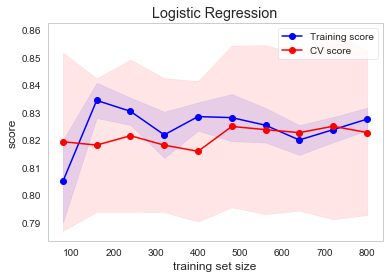

In [95]:
# 绘制学习曲线,
plot_learning_curve(model,
                    'Logistic Regression',
                    X_train,
                    y_train,
                    ylim=None,
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

In [96]:
pd.DataFrame({"columns":X_train.columns, "coef":model.coef_[0]})

,columns,coef
0,Pclass,-0.515190
1,Sex,0.096823
2,Embarked,-0.300235
3,age_band,-0.030703
4,fare_band,0.218287
5,family_size,-1.079178
6,title,-1.007633
7,middle_age,0.749413
8,child,1.332162
9,Deck,0.211684


提交Kaggle后，分数仍然是76.3%，这说明在训练集上的交叉验证分数的提高，并不代表在测试集上就能有提高。
看来我应该直接在平台上进行测试，来判断一个特征是否真正有用。

## 总结与展望

使用逻辑回归对乘客生还结果进行预测，准确率为76.3%。Kaggle上被人使用逻辑回归模型的准确率最高能达到82%左右，说明我的模型还有待优化。

下一步的改进想法：
1. 尝试模型融合。
2. 继续深入挖掘数据的性质，一定有什么重要信息被我遗漏了。